### 泰坦尼克号幸存者
这里是一个「泰坦尼克号幸存者预测」的demo。可以快速熟悉整个流程。
1. 数据处理
2. 特征处理
3. 选择模型
4. 训练
5. 产出结果
数据源：https://ai-training-data-1253534728.cos.ap-beijing.myqcloud.com/public/titanic.zip

请把数据下载到本文件同级别dataset_temp 文件夹中，不要提交到远端库
```

In [1]:
import sys
import pandas as pd
import numpy as np
import sklearn

# 导入一些算法
from sklearn import ensemble
# 用于编码转换
from sklearn.preprocessing import LabelEncoder
# 用于特征选择
from sklearn import feature_selection

from sklearn import model_selection
# 用于评估模型
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 设置绘图风格
mpl.style.use('ggplot')

1. 读取数据并处理

In [2]:
base_path = 'dataset_temp/titanic'
data_train = pd.read_csv(f'{base_path}/train.csv')
data_test = pd.read_csv(f'{base_path}/test.csv')

In [3]:
data_train.head()
data_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# 小写转换,方便后续统一操作
data_train.columns = data_train.columns.str.lower()
data_test.columns = data_test.columns.str.lower()
data_train.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<Axes: xlabel='survived', ylabel='count'>

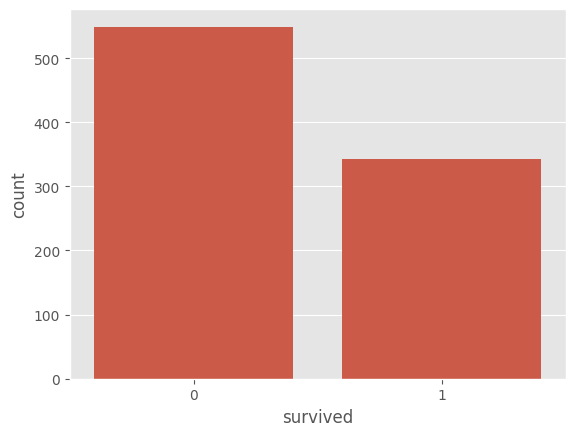

In [5]:

# 用sns绘制直方图，查看survived的情况，查看survived 的聚合情况
sns.countplot(data_train, x='survived')

In [6]:
# 把两个数据集合并起来，方便统一处理
data_all = [ data_train,data_test]

In [7]:
# 开始数据清洗
# 查看缺失值
data_train.isnull().sum()
data_test.isnull().sum()
# 查看数据的描述
data_train.describe(include='all')

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [8]:
data_train.isnull().sum()
data_train['age'].isnull().sum()
data_train['age'].median()
data_train['embarked'].isnull().sum()

2

In [9]:
# 补缺失值
for data_set in data_all:
    data_set['age'].fillna(data_set['age'].median(),inplace=True)    
    data_set['fare'].fillna(data_set['fare'].median(),inplace=True)
    # 港口，如果没有，就用众数填充
    data_set['embarked'].fillna(data_set['embarked'].mode()[0],inplace=True)
    # 删除一些不需要的列
    data_set.drop(['cabin','passengerid','ticket'],axis=1,inplace=True)  


/var/folders/14/djzvbv312951ytxybb9bdcb00000gn/T/ipykernel_38837/3107279956.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_set['age'].fillna(data_set['age'].median(),inplace=True)
/var/folders/14/djzvbv312951ytxybb9bdcb00000gn/T/ipykernel_38837/3107279956.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

In [10]:
data_train.isnull().sum() 
data_test.isnull().sum()

pclass      0
name        0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64

In [11]:
pd.cut(data_train['age'].astype(int),5).value_counts()

age
(16.0, 32.0]     525
(32.0, 48.0]     186
(-0.08, 16.0]    100
(48.0, 64.0]      69
(64.0, 80.0]      11
Name: count, dtype: int64

特征构建

In [12]:

for data_set in data_all:
    data_set['family_size'] = data_set['sibsp'] + data_set['parch'] + 1
    data_set['is_alone'] = 1
    data_set['is_alone'].loc[data_set['family_size'] > 1] = 0
    data_set['title'] = data_set['name'].str.split(',',expand=True)[1].str.split('.',expand=True)[0].str.strip()
 
    # 票价，票价是一个连续值，我们可以把票价分成几个区间,每个区间的人数基本一致
    data_set['fare_bin'] =pd.qcut(data_train['fare'],5)
    # 年龄，这里用cut，每组元素不一样
    data_set['age_bin'] = pd.cut(data_train['age'].astype(int),5)


rarely_title = (data_train['title'].value_counts() < 10)
rarely_title.value_counts()
data_train['title'] = data_train['title'].apply(lambda x: 'Rarely' if rarely_title.loc[x] == True else x)



/var/folders/14/djzvbv312951ytxybb9bdcb00000gn/T/ipykernel_38837/3111048874.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_set['is_alone'].loc[data_set['family_size'] > 1] = 0
/var/folders/14/djzvbv312951ytxybb9bdcb00000gn/T/ipyker

In [13]:

data_train.head()
data_train['survived'].groupby(data_train['title']).mean()


title
Master    0.575000
Miss      0.697802
Mr        0.156673
Mrs       0.792000
Rarely    0.444444
Name: survived, dtype: float64

#### 基于LabelEncoder 构建新的字段
把一些字符串变成机器可以理解的 枚举值

In [14]:
label = LabelEncoder()
for data_set in data_all:
    data_set['sex_code'] = label.fit_transform(data_set['sex'])
    data_set['embarked_code'] = label.fit_transform(data_set['embarked'])
    data_set['title_code'] = label.fit_transform(data_set['title'])
    data_set['fare_code'] = label.fit_transform(data_set['fare_bin'])
    data_set['age_code'] = label.fit_transform(data_set['age_bin'])



In [15]:
data_train.head()
data_train.columns.to_list()
# 选择一些特征来进行训练
target  = ['survived']
features = ['pclass',"sex_code","age_code","fare_code","embarked_code","is_alone","family_size","title_code"]


In [16]:
# 通过pandas 进行编码
finally_data_columns = target+features
data_dummy = pd.get_dummies(data_train[finally_data_columns])
data_dummy_list = data_dummy.columns.to_list()

In [17]:
x_train,x_test,y_train,y_test = model_selection.train_test_split(data_dummy[features],data_dummy[target],random_state=0)

In [18]:
x_train.shape

(668, 8)

### 随机森林实现

In [19]:
# 为了自动处理超参数
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_features='sqrt', random_state=1, n_jobs=-1)

param_grid = {
                "criterion": ['gini','entropy'],
                "min_samples_leaf": [1,  5, 10],
                'min_samples_split': [2, 4, 10,12,16],
                "n_estimators": [50, 100, 400, 700, 1000] 
            }

In [20]:
gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

In [21]:
x_train

,pclass,sex_code,age_code,fare_code,embarked_code,is_alone,family_size,title_code
105,3,1,1,1,2,1,1,2
68,3,0,1,1,2,0,7,1
253,3,1,1,2,2,0,2,2
320,3,1,1,0,2,1,1,2
706,2,0,2,2,2,1,1,3
...,...,...,...,...,...,...,...,...
835,1,0,2,4,0,0,3,1
192,3,0,1,0,2,0,2,1
629,3,1,1,0,1,1,1,2
559,3,0,2,2,2,0,2,3


In [22]:
# 开始训练
gs = gs.fit(x_train, y_train)

/opt/anaconda3/envs/ai_trader/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/ai_trader/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/ai_trader/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/ai_trader/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array

In [23]:
# 准确率
print(gs.best_score_)
# 把gs fit 完的模型保存成文件
# import joblib
# joblib.dump(gs.best_estimator_, 'model/rf.pkl')


0.8308689855775059


In [24]:
# 最佳参数
print(gs.best_params_)

# 查看特征的重要性

# pd.concat(pd.DataFrame(x_train[:,1:]).columns)

{'criterion': 'entropy', 'min_samples_leaf': 5, 'min_samples_split': 16, 'n_estimators': 100}


In [25]:
# 创建一个新的随机森林对象，放入最佳参数, 重新fit
rf2 = RandomForestClassifier(criterion='gini', 
                             n_estimators=50,
                             min_samples_split=2,
                             min_samples_leaf=1,
                             max_features='sqrt',
                             random_state=1,
                             n_jobs=-1)
rf2.fit(x_train, y_train)

/opt/anaconda3/envs/ai_trader/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=1)

In [44]:
# pd.DataFrame(x_train[:,1:].columns,columns=['Variable'])
df1 = pd.DataFrame(x_train.columns,columns=['Variable'])
df2 = pd.DataFrame(rf2.feature_importances_,columns=['Importance'])
pd.concat([df1,df2],axis=1).sort_values(by='Importance',ascending=False)


,Variable,Importance
1,sex_code,0.246082
7,title_code,0.200420
3,fare_code,0.134514
0,pclass,0.120254
6,family_size,0.114268
2,age_code,0.102925
4,embarked_code,0.059219
5,is_alone,0.022317


In [48]:
x_test.columns


Index(['pclass', 'sex_code', 'age_code', 'fare_code', 'embarked_code',
       'is_alone', 'family_size', 'title_code'],
      dtype='object')

In [45]:
# 正式预测
pred = rf2.predict(x_test)
pred_df = pd.DataFrame(pred,columns=['survived'])
pred_df.head()

,survived
0,1
1,0
2,0
3,1
4,0


In [49]:
y_test.head()

,survived
495,0
648,0
278,0
31,1
255,1
